In [ ]:
# !pip install numpy
# !pip install pandas
# !pip install seaborn
# !pip install sktime

## SECTOR A ##

## Package Imports ##

In [1]:
import warnings

# Import data loading and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

# Time serie components
from statsmodels.tsa.seasonal import seasonal_decompose

# Chequear la Estacionariedad. Prueba de Dickey Fuller Aumentada.
from statsmodels.tsa.stattools import adfuller

# Import for ts analysis
from statsmodels.tsa.seasonal import MSTL
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# hide warnings
warnings.filterwarnings("ignore")

### SkTime es una API unificada que contiene una serie de herramientas para hacer timeserie forecasting con algoritmos clasicos ML-style, con una interface similar a Sckit-Learn. ###

SKTIME PACKAGE

In [2]:
# Import for ts forecasting
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.model_selection import temporal_train_test_split

from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.theta import ThetaForecaster
from sktime.forecasting.tbats import TBATS

from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
from sktime.performance_metrics.forecasting import mean_absolute_error
from sktime.performance_metrics.forecasting import mean_squared_error

from sktime.utils.plotting import plot_series

## OBJETIVO: OBTENER MODELOS QUE PERMITAN HACER PREDICCIONES A CORTO PLAZO (DE UNA HORA). SHORT-TERM FORECASTING. ##

## Preparacion de los datos ##

DESCRIPCION DEL DATASET: 
- La columna count, es la cantidad de aeronaves en un sector de control (SECTOR A).

- La columna timestamp, es la marca de tiempo fecha/hora con intervalos (frecuencia de muestreo) de 15 minutos, desde las 14:00 UTC hasta las 23:59 UTC.

- Desde el 1-1-2023 hasta 12-06-2023 en el horario de la noche desde las 21:15 hasta 23:59 UTC y en la madrugada desde las 00:15 hasta las 13:45 UTC no hay datos.

- Para garantizar una secuencia ininterrumpida en la serie se completaron los datos faltantes tomando el valor minimo de la mediana de cada dia de semana de cada mes ya que el movimiento de aeronaves tiene un comportamiento historico similar para cada dia de semana del mes.

- Se decidio tomar el valor minimo para completar los datos faltantes ya que en los horarios especificados mas arriba son los de menor flujo aereo.

Load dataset and set correct data type timestamp column.

In [35]:
sector_data_full = 'sectorA_full.csv'
df = pd.read_csv(sector_data_full, usecols=['timestamp', 'A'], parse_dates=['timestamp'])

# Slicing Time Series. Set the column as the index of the dataframe.
df.set_index('timestamp', inplace=True)

# Rename column.
df = df.rename(columns={'A':'count'})

# Set frequency to 15 min.
df = df.asfreq('15T')

EXPLORATORY DATA ANALYSIS

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 35095 entries, 2023-01-01 00:15:00 to 2024-01-01 13:45:00
Freq: 15min
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   count   35095 non-null  float64
dtypes: float64(1)
memory usage: 548.4 KB


In [5]:
df.describe()

count
count  35095.000000
mean      10.207124
std        2.583737
min        0.000000
25%        9.000000
50%       10.000000
75%       11.000000
max       30.000000

In [6]:
# Check dataframe index.
df.index

DatetimeIndex(['2023-01-01 00:15:00', '2023-01-01 00:30:00',
               '2023-01-01 00:45:00', '2023-01-01 01:00:00',
               '2023-01-01 01:15:00', '2023-01-01 01:30:00',
               '2023-01-01 01:45:00', '2023-01-01 02:00:00',
               '2023-01-01 02:15:00', '2023-01-01 02:30:00',
               ...
               '2024-01-01 11:30:00', '2024-01-01 11:45:00',
               '2024-01-01 12:00:00', '2024-01-01 12:15:00',
               '2024-01-01 12:30:00', '2024-01-01 12:45:00',
               '2024-01-01 13:00:00', '2024-01-01 13:15:00',
               '2024-01-01 13:30:00', '2024-01-01 13:45:00'],
              dtype='datetime64[ns]', name='timestamp', length=35095, freq=None)

Exploracion visual de los datos.

In [7]:
print(df.head())
print(df.loc['2023-06-12 14':'2023-07-31'])
print(df.tail())

                     count
timestamp                 
2023-01-01 00:15:00   11.0
2023-01-01 00:30:00   11.0
2023-01-01 00:45:00   11.0
2023-01-01 01:00:00   11.0
2023-01-01 01:15:00   11.0
                     count
timestamp                 
2023-06-12 14:00:00    6.0
2023-06-12 14:15:00    6.0
2023-06-12 14:30:00    8.0
2023-06-12 14:45:00   11.0
2023-06-12 15:00:00   11.0
...                    ...
2023-07-31 22:45:00   14.0
2023-07-31 23:00:00    7.0
2023-07-31 23:15:00    5.0
2023-07-31 23:30:00   10.0
2023-07-31 23:45:00   10.0

[4744 rows x 1 columns]
                     count
timestamp                 
2024-01-01 12:45:00    9.5
2024-01-01 13:00:00    9.5
2024-01-01 13:15:00    9.5
2024-01-01 13:30:00    9.5
2024-01-01 13:45:00    9.5


## La capacidad del sector de control A es de 20 aeronaves ##

PLOT FULL DATAFRAME

(<Figure size 1600x400 with 1 Axes>, <Axes: >)

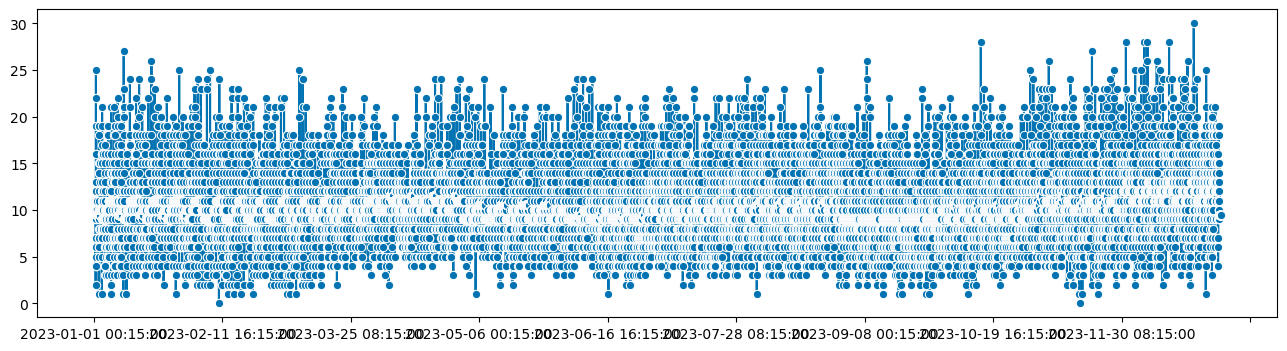

In [8]:
# Plotting for visualization usin sktime library.
plot_series(df)

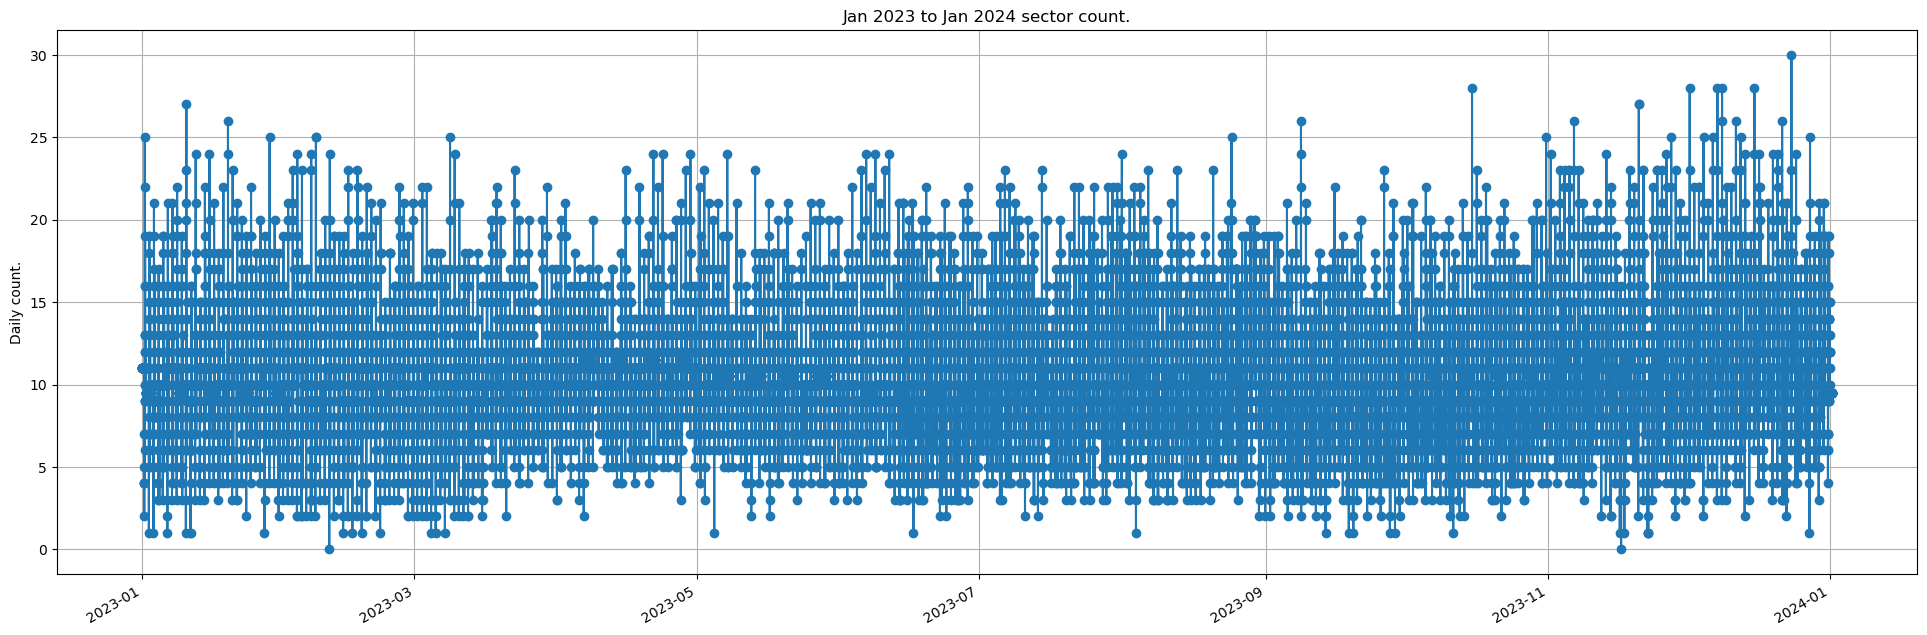

In [9]:
# Plot using matplotlib
#fig, ax = plt.subplot()
fig, ax = plt.subplots(figsize=(24, 8))
ax.grid(True)
fig.autofmt_xdate() # inclina las fechas en el eje x.

# Set dataframe, title and label
ax.plot(df, marker='o', linestyle='-')
ax.set_ylabel( 'Daily count.')
ax.set_title('Jan 2023 to Jan 2024 sector count.')

# set x-axis major ticks to weekly interval, on Mondays.
#date_locator = mdates.WeekdayLocator(byweekday=mdates.MONDAY)
#ax.xaxis.set_major_locator(date_locator)

# Format x-tick labels as 3-letter month name and day number
date_fmt_dhm = mdates.DateFormatter('%d-%H:%M')
date_fmt_ym = mdates.DateFormatter('%Y-%m')

# Get major locator 
date_fmt_ml = mdates.ConciseDateFormatter(ax.xaxis.get_major_locator())

# set format
ax.xaxis.set_major_formatter(date_fmt_ym)

Ploteo mensual (Meses de ENERO / FEBRERO 2023)

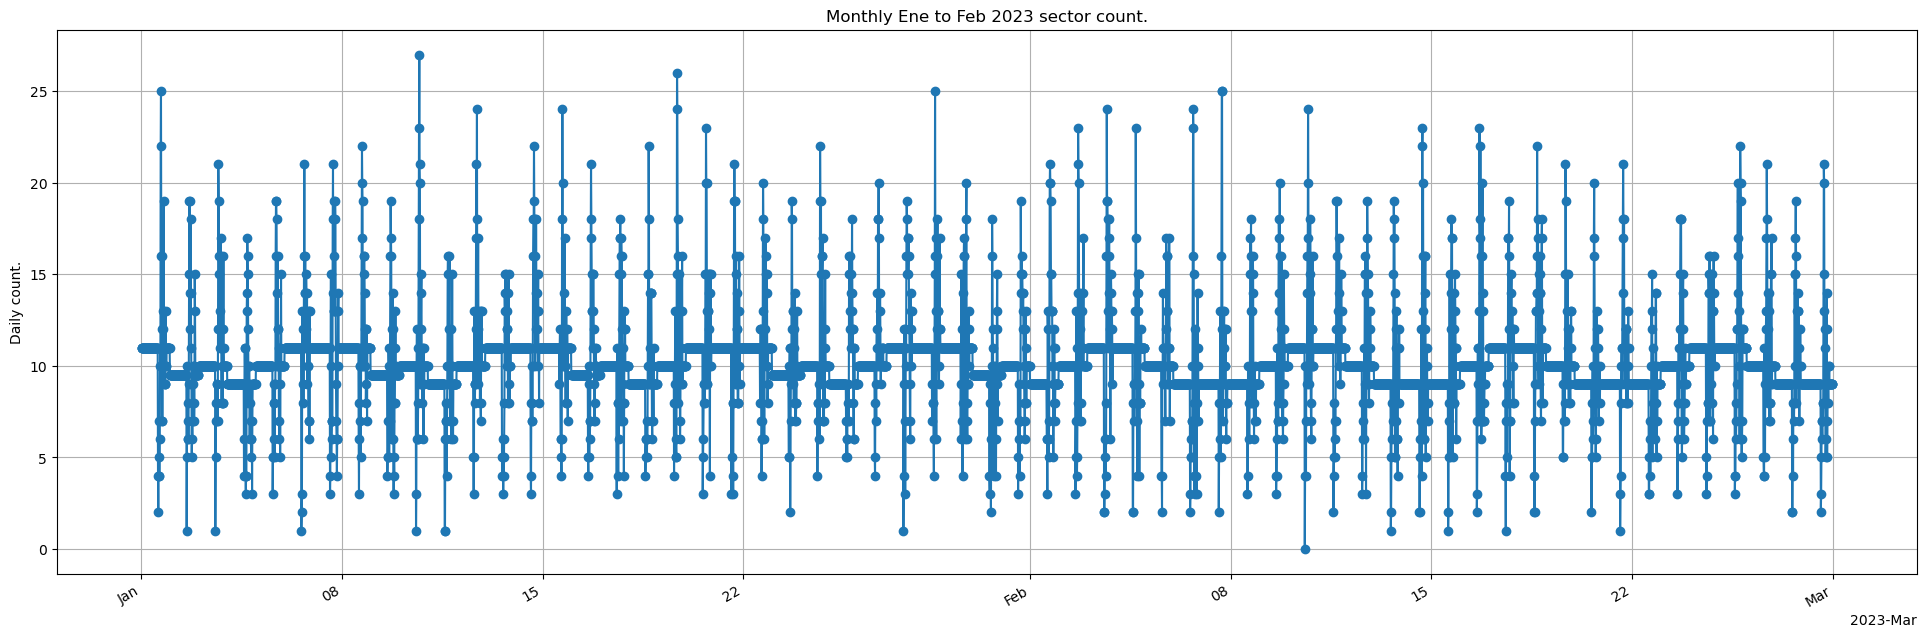

In [10]:
#fig, ax = plt.subplot()
fig, ax = plt.subplots(figsize=(24, 8))
ax.grid(True)
fig.autofmt_xdate() # inclina las fechas en el eje x.

# Explore Jueves 14 Dic, Viernes 15 Dic y Sab 16 Dic.
ax.plot(df.loc['2023-01':'2023-02', 'count'], marker='o', linestyle='-')
ax.set_ylabel( 'Daily count.')
ax.set_title('Monthly Ene to Feb 2023 sector count.')

# set x-axis major ticks to weekly interval, on Mondays.
#date_locator = mdates.WeekdayLocator(byweekday=mdates.MONDAY)
#ax.xaxis.set_major_locator(date_locator)

# Format x-tick labels as 3-letter month name and day number
date_fmt_dhm = mdates.DateFormatter('%d-%H:%M')
date_fmt_ym = mdates.DateFormatter('%Y-%m')

# Get major locator 
date_fmt_ml = mdates.ConciseDateFormatter(ax.xaxis.get_major_locator())
ax.xaxis.set_major_formatter(date_fmt_ml)

Ploteo mensual (Meses de NOV / DIC 2023)

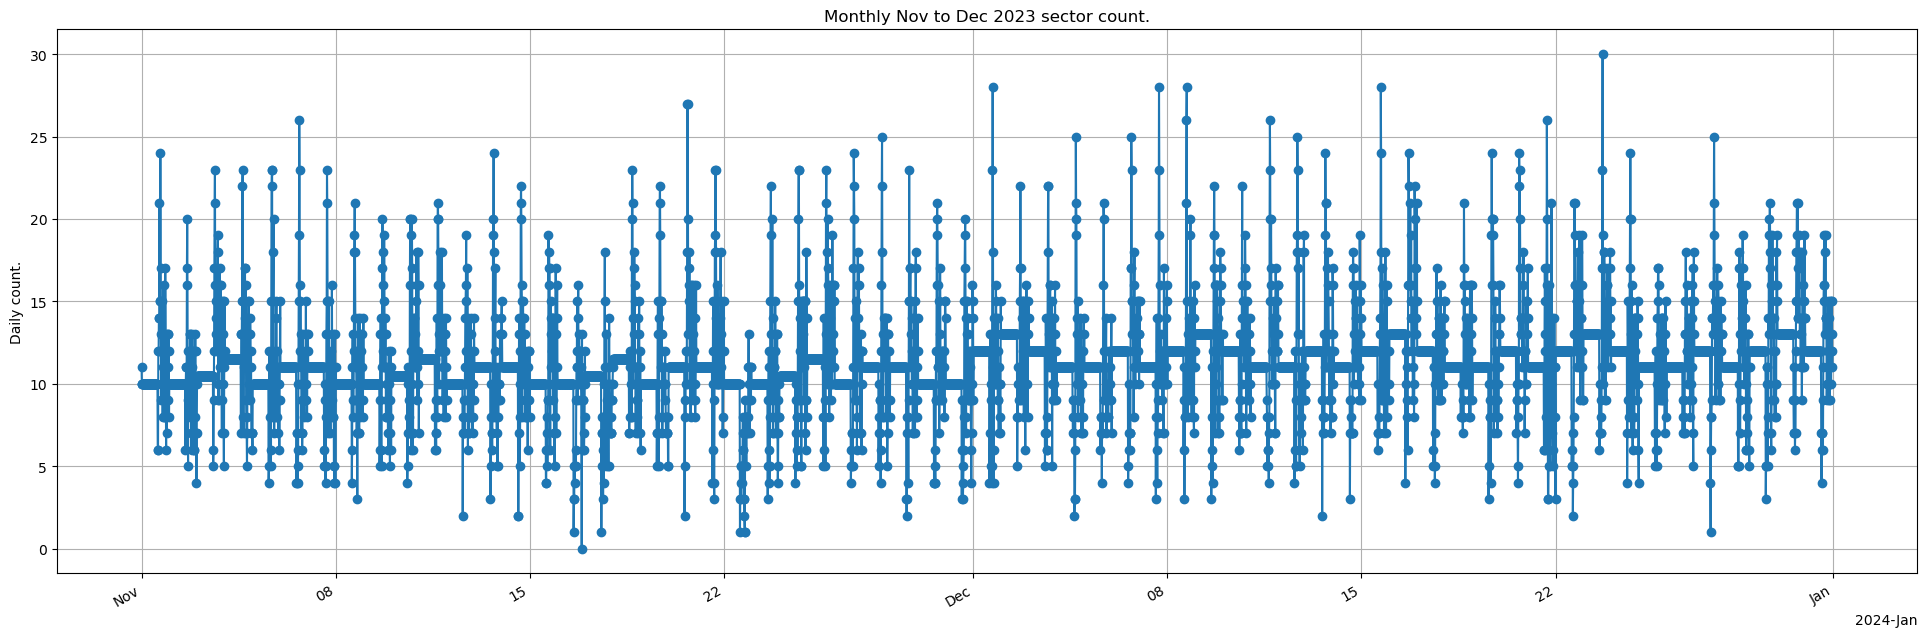

In [11]:
#fig, ax = plt.subplot()
fig, ax = plt.subplots(figsize=(24, 8))
ax.grid(True)
fig.autofmt_xdate() # inclina las fechas en el eje x.

# Explore Jueves 14 Dic, Viernes 15 Dic y Sab 16 Dic.
ax.plot(df.loc['2023-11':'2023-12', 'count'], marker='o', linestyle='-')
ax.set_ylabel( 'Daily count.')
ax.set_title('Monthly Nov to Dec 2023 sector count.')

# set x-axis major ticks to weekly interval, on Mondays.
#date_locator = mdates.WeekdayLocator(byweekday=mdates.MONDAY)
#ax.xaxis.set_major_locator(date_locator)

# Format x-tick labels as 3-letter month name and day number
date_fmt_dhm = mdates.DateFormatter('%d-%H:%M')
date_fmt_ym = mdates.DateFormatter('%Y-%m')

# Get major locator 
date_fmt_ml = mdates.ConciseDateFormatter(ax.xaxis.get_major_locator())
ax.xaxis.set_major_formatter(date_fmt_ml)

Ploteo diario (Dias 14 al 16 Dic 2023)

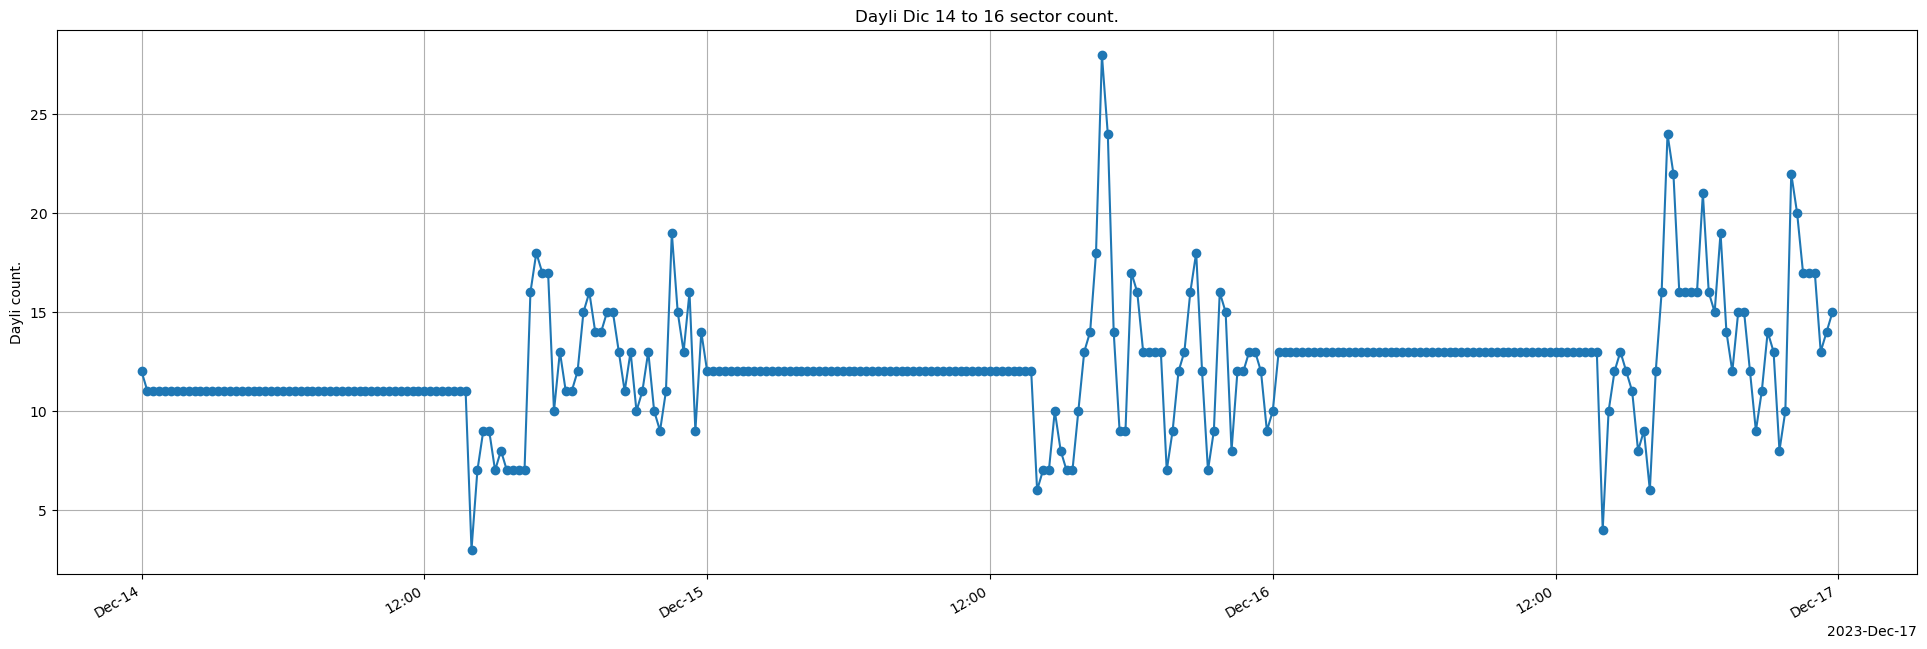

In [12]:
#fig, ax = plt.subplot()
fig, ax = plt.subplots(figsize=(24, 8))
ax.grid(True)
fig.autofmt_xdate() # inclina las fechas en el eje x.

# Explore Jueves 14 Dic, Viernes 15 Dic y Sab 16 Dic.
ax.plot(df.loc['2023-12-14':'2023-12-16', 'count'], marker='o', linestyle='-')
ax.set_ylabel( 'Dayli count.')
ax.set_title('Dayli Dic 14 to 16 sector count.')

# set x-axis major ticks to weekly interval, on Mondays.
#date_locator = mdates.WeekdayLocator(byweekday=mdates.MONDAY)
#ax.xaxis.set_major_locator(date_locator)

# Format x-tick labels as 3-letter month name and day number
date_fmt_dhm = mdates.DateFormatter('%d-%H:%M')
date_fmt_ym = mdates.DateFormatter('%Y-%m')

# Get major locator 
date_fmt_ml = mdates.ConciseDateFormatter(ax.xaxis.get_major_locator())
ax.xaxis.set_major_formatter(date_fmt_ml)

# Comprobacion de la estacionariedad. #

La estacionariedad se refiere a la estabilidad de las propiedades estadisticas de los datos a lo largo del tiempo.

Prueba parametrica de Dickey Fuller Aumentada.
-----------------------------------------------
Las Hipotesis para la prueba:

La Hipotesis Nula (H0): Si existe una raiz unitaria (alfa=1), indica que la serie es NO ES ESTACIONARIA.

Interpretacion de los resultados:
- Si el valor p es de menos del 5% (nivel de significancia de 0.05), se puede rechazar H(0), de que existe una raiz unitaria.
- Si el estadistico DF es mas negativo que los valores criticos 1%, 5% y 10%, rechace H(0). Nota: Cuanto mas negativo 
sea el estadistico de prueba DF (ADF Test), mas fuerte sera la evidencia para rechazar la hipotesis nula de raiz unitaria.

Cumplida estas condiciones, se rechaza la hipotesis nula y se infiere que LA SERIE ES ESTACIONARIA.


In [13]:
# Chequear la Estacionariedad. Prueba de Dickey Fuller Aumentada.
 
result = adfuller(df.values.flatten())   #, autolag='AIC'-Minimice el Criterio de Informacion de Akaike, 'BIC'-Criterio de Informacion Bayeciano

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[4].items():
    print('Critical Values:')
    print(f'  {key},    {value}')

ADF Statistic: -15.347009
p-value: 0.000000
Critical Values:
  1%,    -3.430536626878884
Critical Values:
  5%,    -2.8616224844717495
Critical Values:
  10%,    -2.5668139038913576


Interpretacion de los resultados:
- El p-value: 0.000000 es menor que el nivel de significancia 0.05.
- ADF Statistics: -15.347009 es mas negativo que los valores criticos de  1%, 5% y 10%.

Ambos resultados son evidencias que se puede rechazar H(0) y se infiere que LA SERIE ES ESTACIONARIA.

## ANALISIS DE COMPONENTES DE LA SERIE ##

### REMUESTRO (RESAMPLING) de los datos ###

In [4]:
# Compute date time variables used later in plotting
df["week"] = df.index.isocalendar().week
df["day_of_month"] = df.index.day
df["month"] = df.index.month
df

count  week  day_of_month  month
timestamp                                            
2023-01-01 00:15:00   11.0    52             1      1
2023-01-01 00:30:00   11.0    52             1      1
2023-01-01 00:45:00   11.0    52             1      1
2023-01-01 01:00:00   11.0    52             1      1
2023-01-01 01:15:00   11.0    52             1      1
...                    ...   ...           ...    ...
2024-01-01 12:45:00    9.5     1             1      1
2024-01-01 13:00:00    9.5     1             1      1
2024-01-01 13:15:00    9.5     1             1      1
2024-01-01 13:30:00    9.5     1             1      1
2024-01-01 13:45:00    9.5     1             1      1

[35095 rows x 4 columns]

In [15]:
print(df.loc['2023-06-12 14':'2023-07-31'])

                     count  week  day_of_month  month
2023-06-12 14:00:00    6.0    24            12      6
2023-06-12 14:15:00    6.0    24            12      6
2023-06-12 14:30:00    8.0    24            12      6
2023-06-12 14:45:00   11.0    24            12      6
2023-06-12 15:00:00   11.0    24            12      6
...                    ...   ...           ...    ...
2023-07-31 22:45:00   14.0    31            31      7
2023-07-31 23:00:00    7.0    31            31      7
2023-07-31 23:15:00    5.0    31            31      7
2023-07-31 23:30:00   10.0    31            31      7
2023-07-31 23:45:00   10.0    31            31      7

[4744 rows x 4 columns]


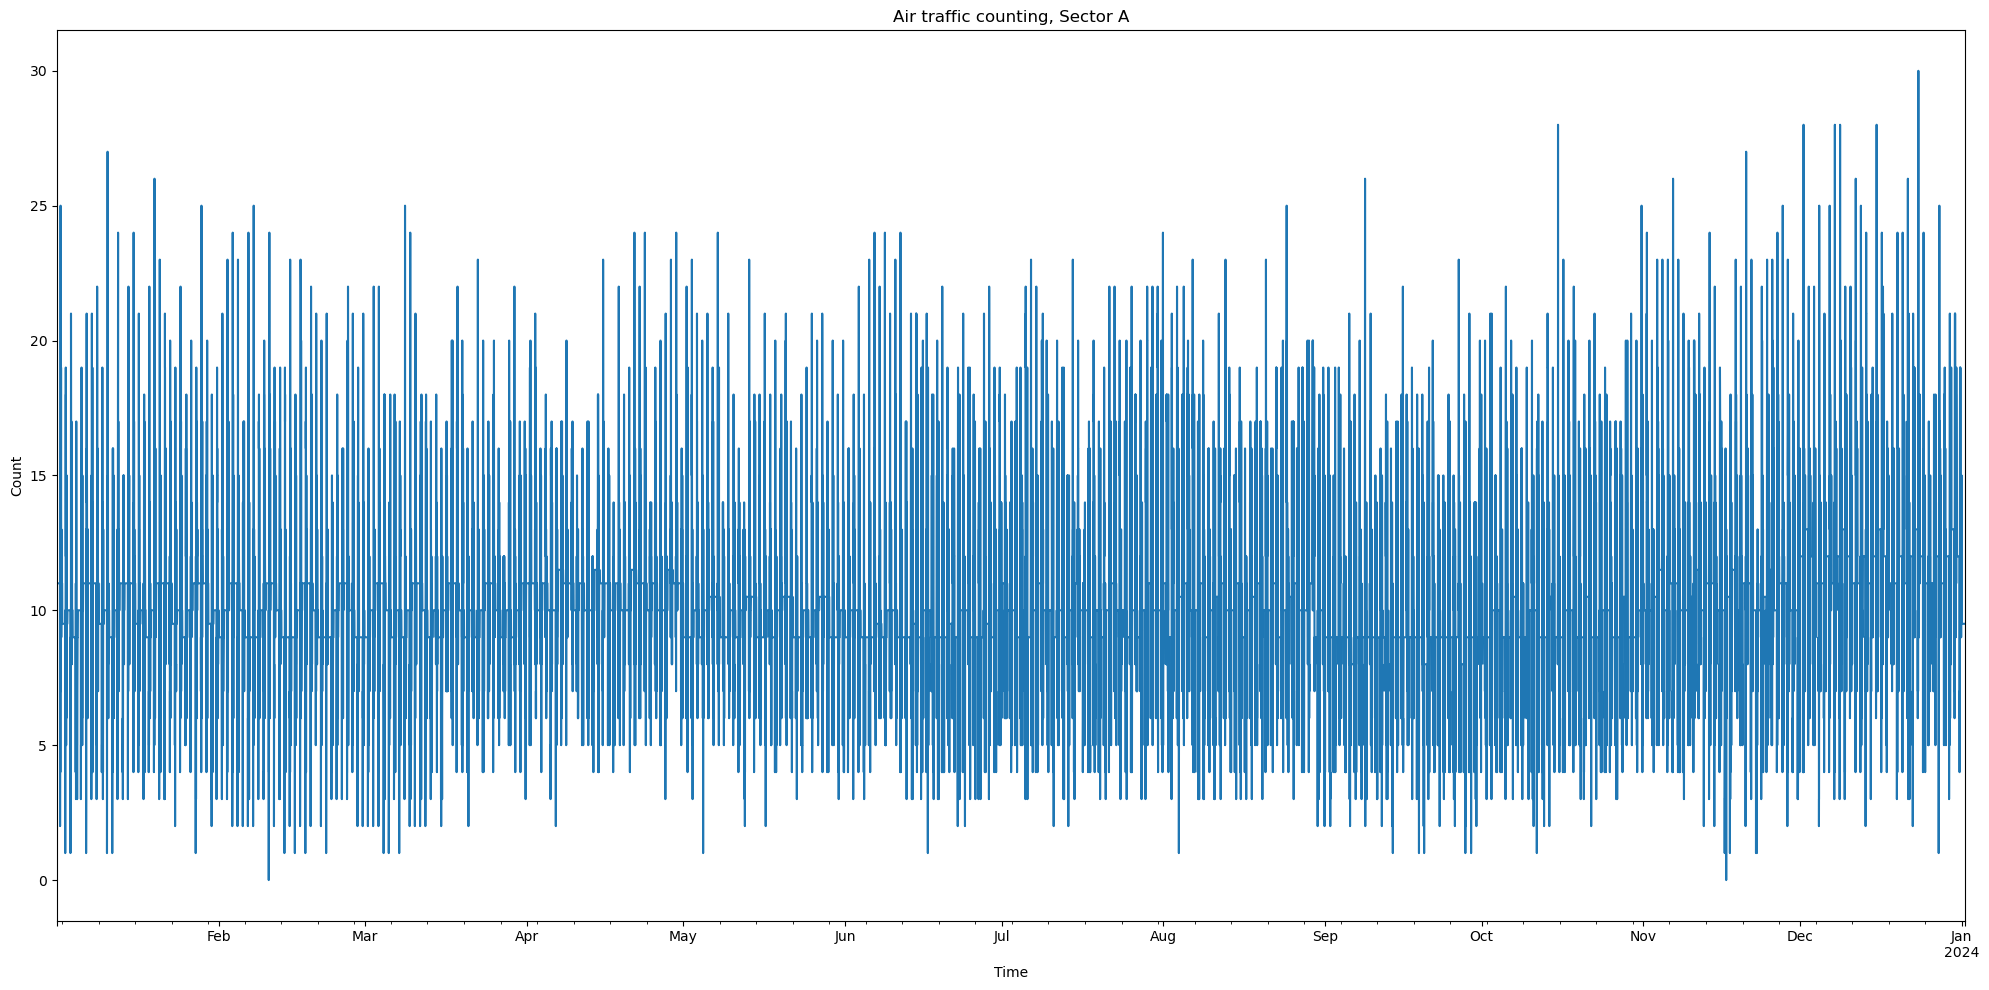

In [16]:
# Plot the time series (frequency count 15min )
ax = df.plot(y="count", figsize=[20, 10], legend=False)
ax.set_ylabel("Count")
ax.set_xlabel("Time")
ax.set_title("Air traffic counting, Sector A")
plt.tight_layout()

RESAMPLE TO HOURLY

In [6]:
# Resampling Time Series Data. La logica detras del metodo resample() es similar al metodo groupby(). Agrupa datos dentro de cualquier
# perido posible. Podemos usar este metodo tanto para aumentar como disminuir la resolucion. Al reducir la resolucion, se reduce 
# la frecuencia de los datos de series temporales (ts), ejemplo al convertir datos de ts horarias en ts diarios y de diarios a mensuales. 

# Remuestreo de Conteo cada 15 minutos a promedio horario (se obtiene el promedio horario de las 4 metricas que se hace en una hora).

# Esta variante mantiene los nombres de columnas
df_h = df.resample('h').mean()

In [18]:
#print(df_h.head())
print(df_h.tail())

                     count  week  day_of_month  month
2024-01-01 09:00:00    9.5   1.0           1.0    1.0
2024-01-01 10:00:00    9.5   1.0           1.0    1.0
2024-01-01 11:00:00    9.5   1.0           1.0    1.0
2024-01-01 12:00:00    9.5   1.0           1.0    1.0
2024-01-01 13:00:00    9.5   1.0           1.0    1.0


In [19]:
print(df_h.loc['2023-06-12 14':'2023-07-31'])

                     count  week  day_of_month  month
2023-06-12 14:00:00   7.75  24.0          12.0    6.0
2023-06-12 15:00:00  13.75  24.0          12.0    6.0
2023-06-12 16:00:00  13.00  24.0          12.0    6.0
2023-06-12 17:00:00  11.25  24.0          12.0    6.0
2023-06-12 18:00:00  14.00  24.0          12.0    6.0
...                    ...   ...           ...    ...
2023-07-31 19:00:00   9.75  31.0          31.0    7.0
2023-07-31 20:00:00   6.25  31.0          31.0    7.0
2023-07-31 21:00:00  10.50  31.0          31.0    7.0
2023-07-31 22:00:00  18.75  31.0          31.0    7.0
2023-07-31 23:00:00   8.00  31.0          31.0    7.0

[1186 rows x 4 columns]


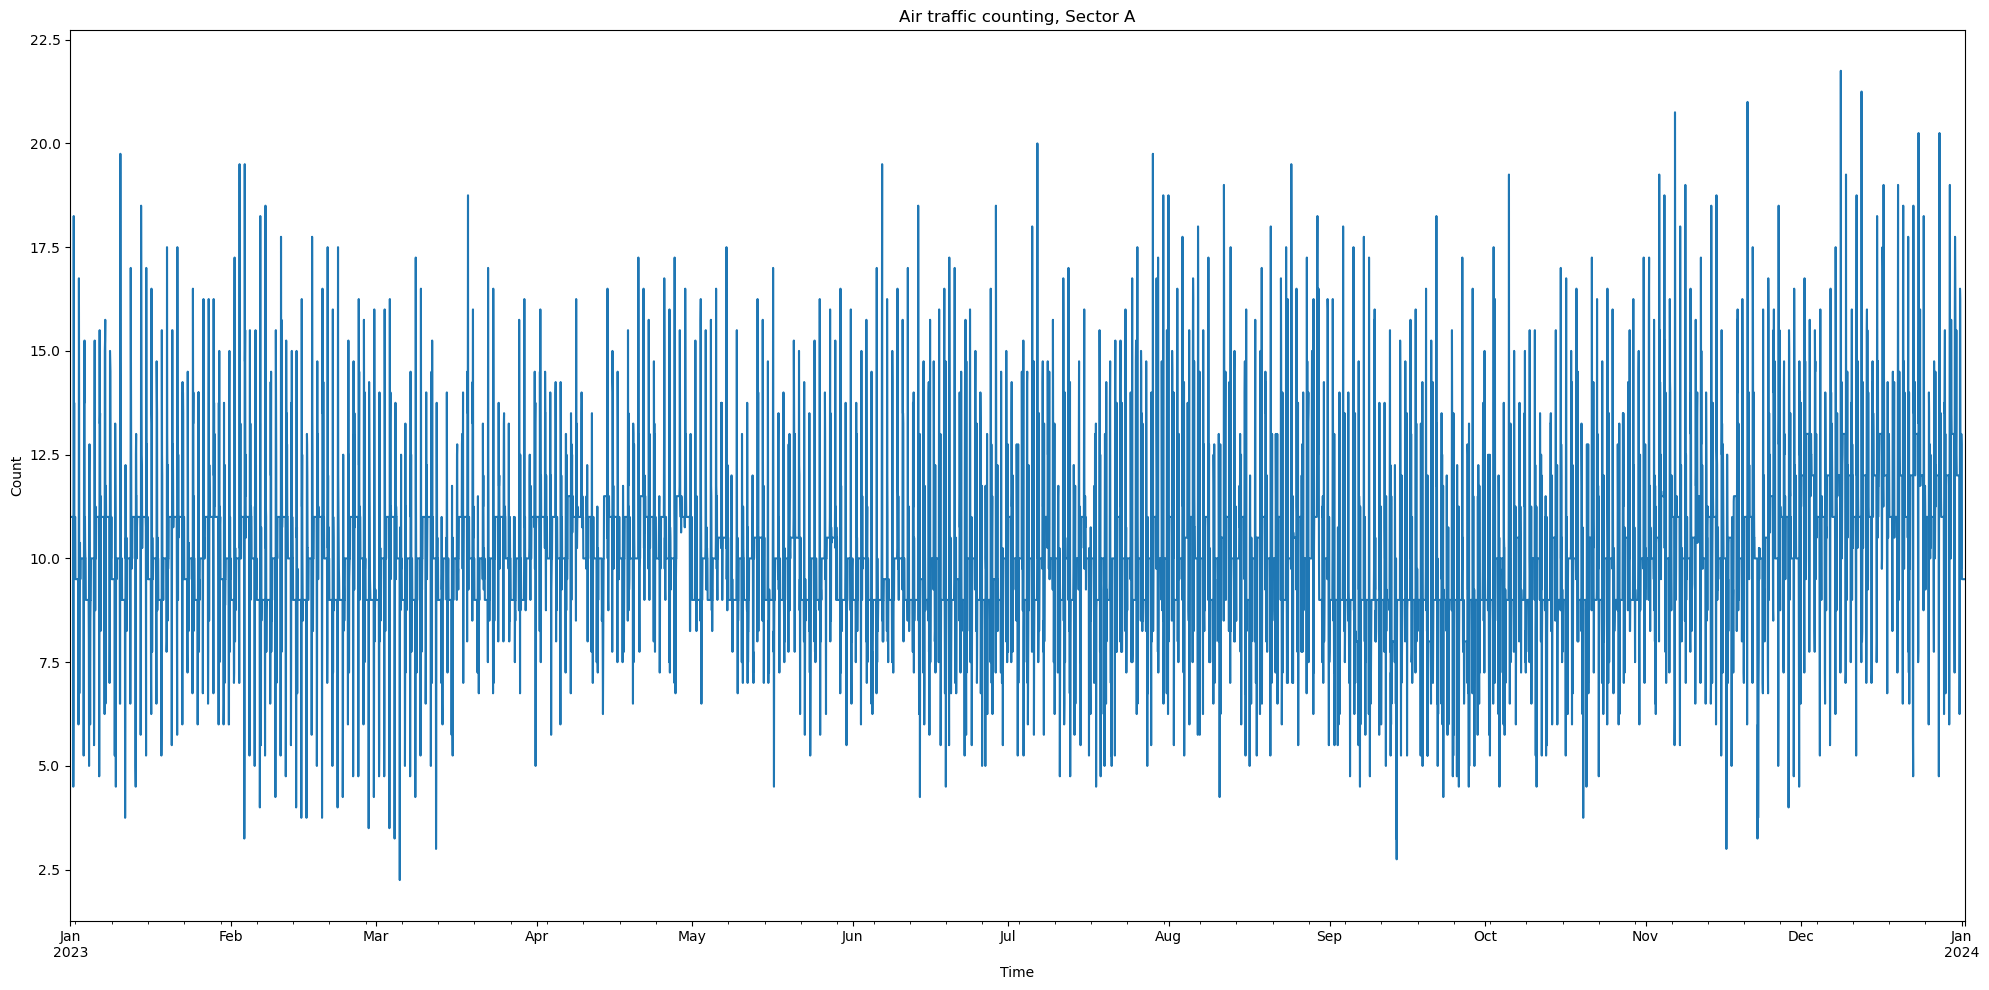

In [20]:
# Plot the time series (frequency count 1 hour)
ax = df_h.plot(y="count", figsize=[20, 10], legend=False)
ax.set_ylabel("Count")
ax.set_xlabel("Time")
ax.set_title("Air traffic counting, Sector A")
plt.tight_layout()

## Air traffic counting, Sector A by month Jan to May.

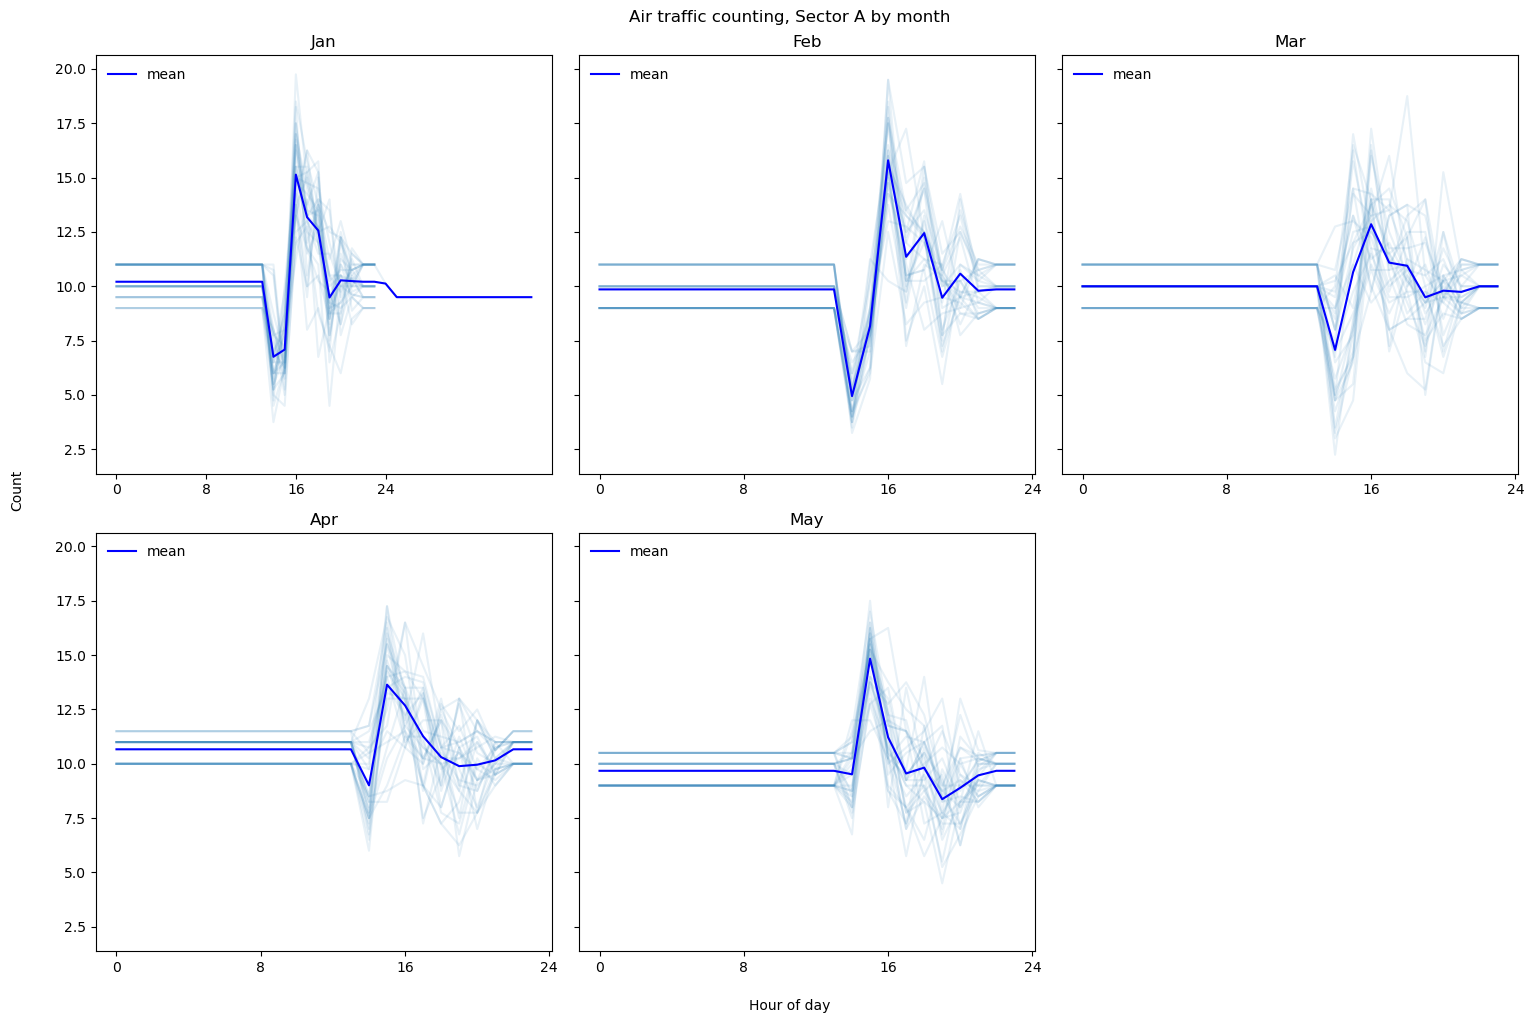

In [21]:
# Plot the count demand for each day. Hour of day
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=[15, 10], sharey=True)
ax = ax.flatten()
sns_blue = sns.color_palette(as_cmap=True)[0]
MONTHS = ["Jan", "Feb", "Mar", "Apr", "May"]
for ix, month in enumerate(MONTHS):
    # Plot individual ts
    daily_ts = []
    for _, ts in (
        df_h[["count", "day_of_month", "month"]]
        .query(f"month == {ix+1}")
        .groupby("day_of_month")
    ):
        daily_ts.append(ts.reset_index()["count"])
        ts.reset_index()["count"].plot(
            alpha=0.1, ax=ax[ix], color=sns_blue, label="_no_legend_"
        )
        ax[ix].set_xticks(np.arange(0, len(ts) + 1, 8))
        ax[ix].set_title(month)

    # Plot the mean ts
    pd.concat(daily_ts, axis=1).mean(axis=1).plot(
        ax=ax[ix], color="blue", label="mean", legend=True
    )
    ax[ix].legend(loc="upper left", frameon=False)

    if month in ("Ago", "Sep"):
        ax[ix].tick_params(
            axis="x", which="both", bottom=False, top=False, labelbottom=False
        )

fig.text(0.5, -0.02, "Hour of day", ha="center")
fig.text(-0.02, 0.5, "Count", va="center", rotation="vertical")
fig.suptitle("Air traffic counting, Sector A by month")
fig.delaxes(ax[-1])
fig.tight_layout()

Air traffic counting, Sector A by all months.

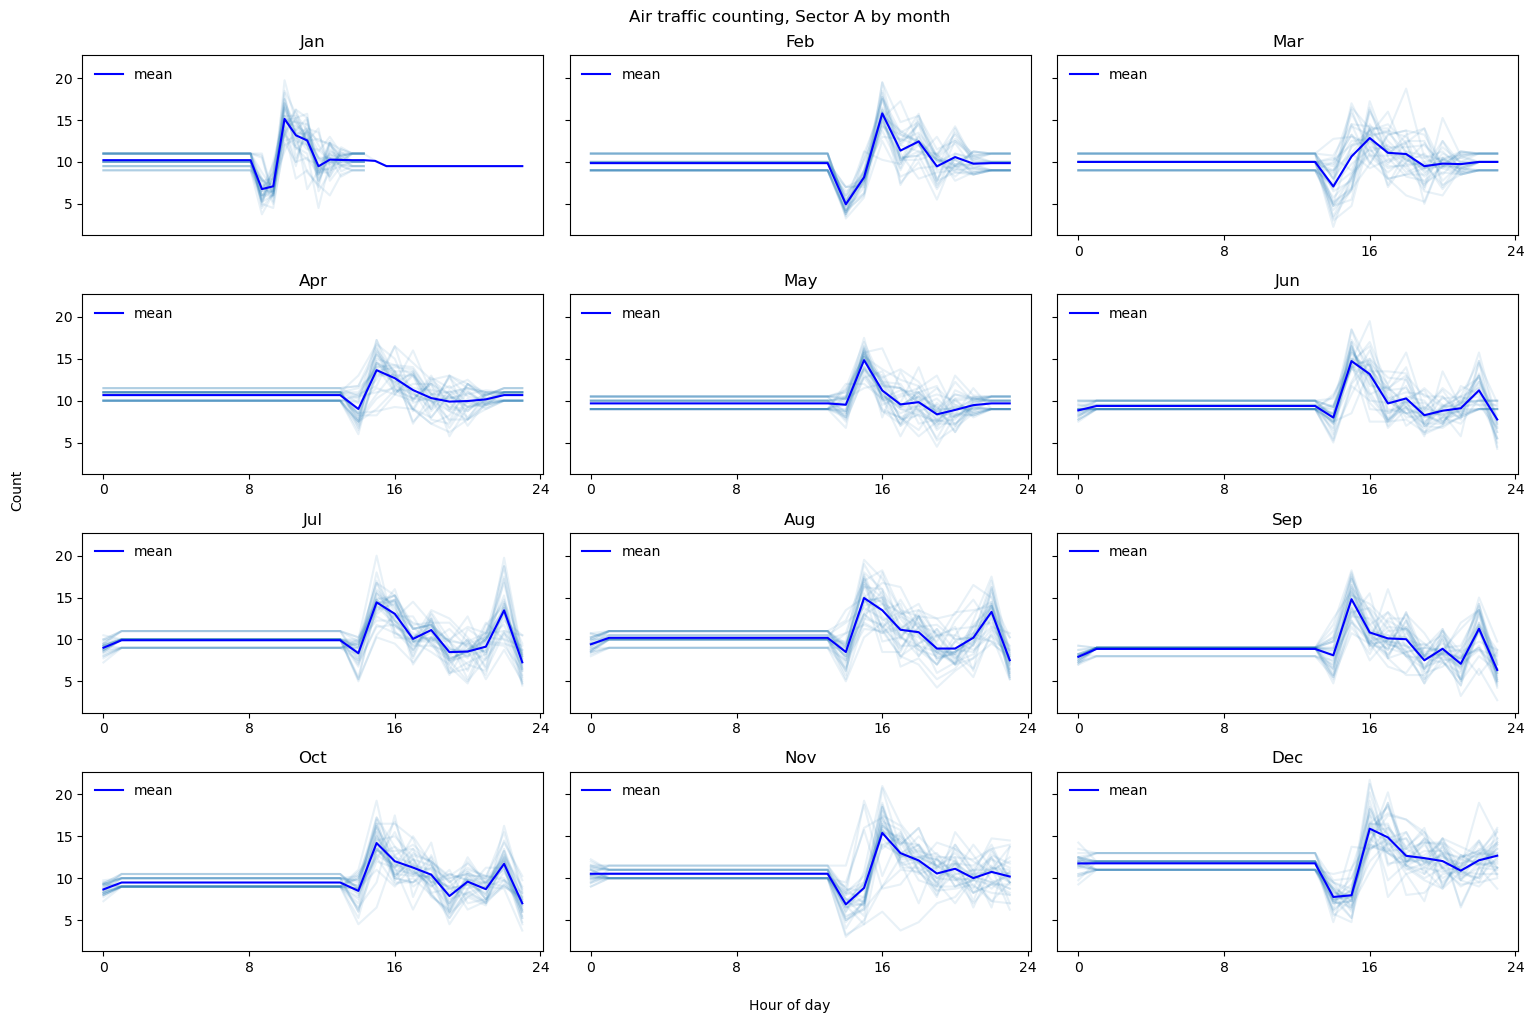

In [ ]:
# Plot the count demand for each day
fig, ax = plt.subplots(nrows=4, ncols=3, figsize=[15, 10], sharey=True)
ax = ax.flatten()
sns_blue = sns.color_palette(as_cmap=True)[0]
MONTHS = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
for ix, month in enumerate(MONTHS):

    # Plot individual ts
    daily_ts = []
    for _, ts in (
        df_h[["count", "day_of_month", "month"]]
        .query(f"month == {ix+1}")
        .groupby("day_of_month")
    ):
        daily_ts.append(ts.reset_index()["count"])
        ts.reset_index()["count"].plot(
            alpha=0.1, ax=ax[ix], color=sns_blue, label="_no_legend_"
        )
        ax[ix].set_xticks(np.arange(0, len(ts) + 1, 8))
        ax[ix].set_title(month)

    # Plot the mean ts
    pd.concat(daily_ts, axis=1).mean(axis=1).plot(
        ax=ax[ix], color="blue", label="mean", legend=True
    )
    ax[ix].legend(loc="upper left", frameon=False)

    if month in ("Jan", "Feb"):
        ax[ix].tick_params(
            axis="x", which="both", bottom=False, top=False, labelbottom=False
        )

fig.text(0.5, -0.02, "Hour of day", ha="center")
fig.text(-0.02, 0.5, "Count", va="center", rotation="vertical")
fig.suptitle("Air traffic counting, Sector A by month")
#fig.delaxes(ax[-1])
fig.tight_layout()

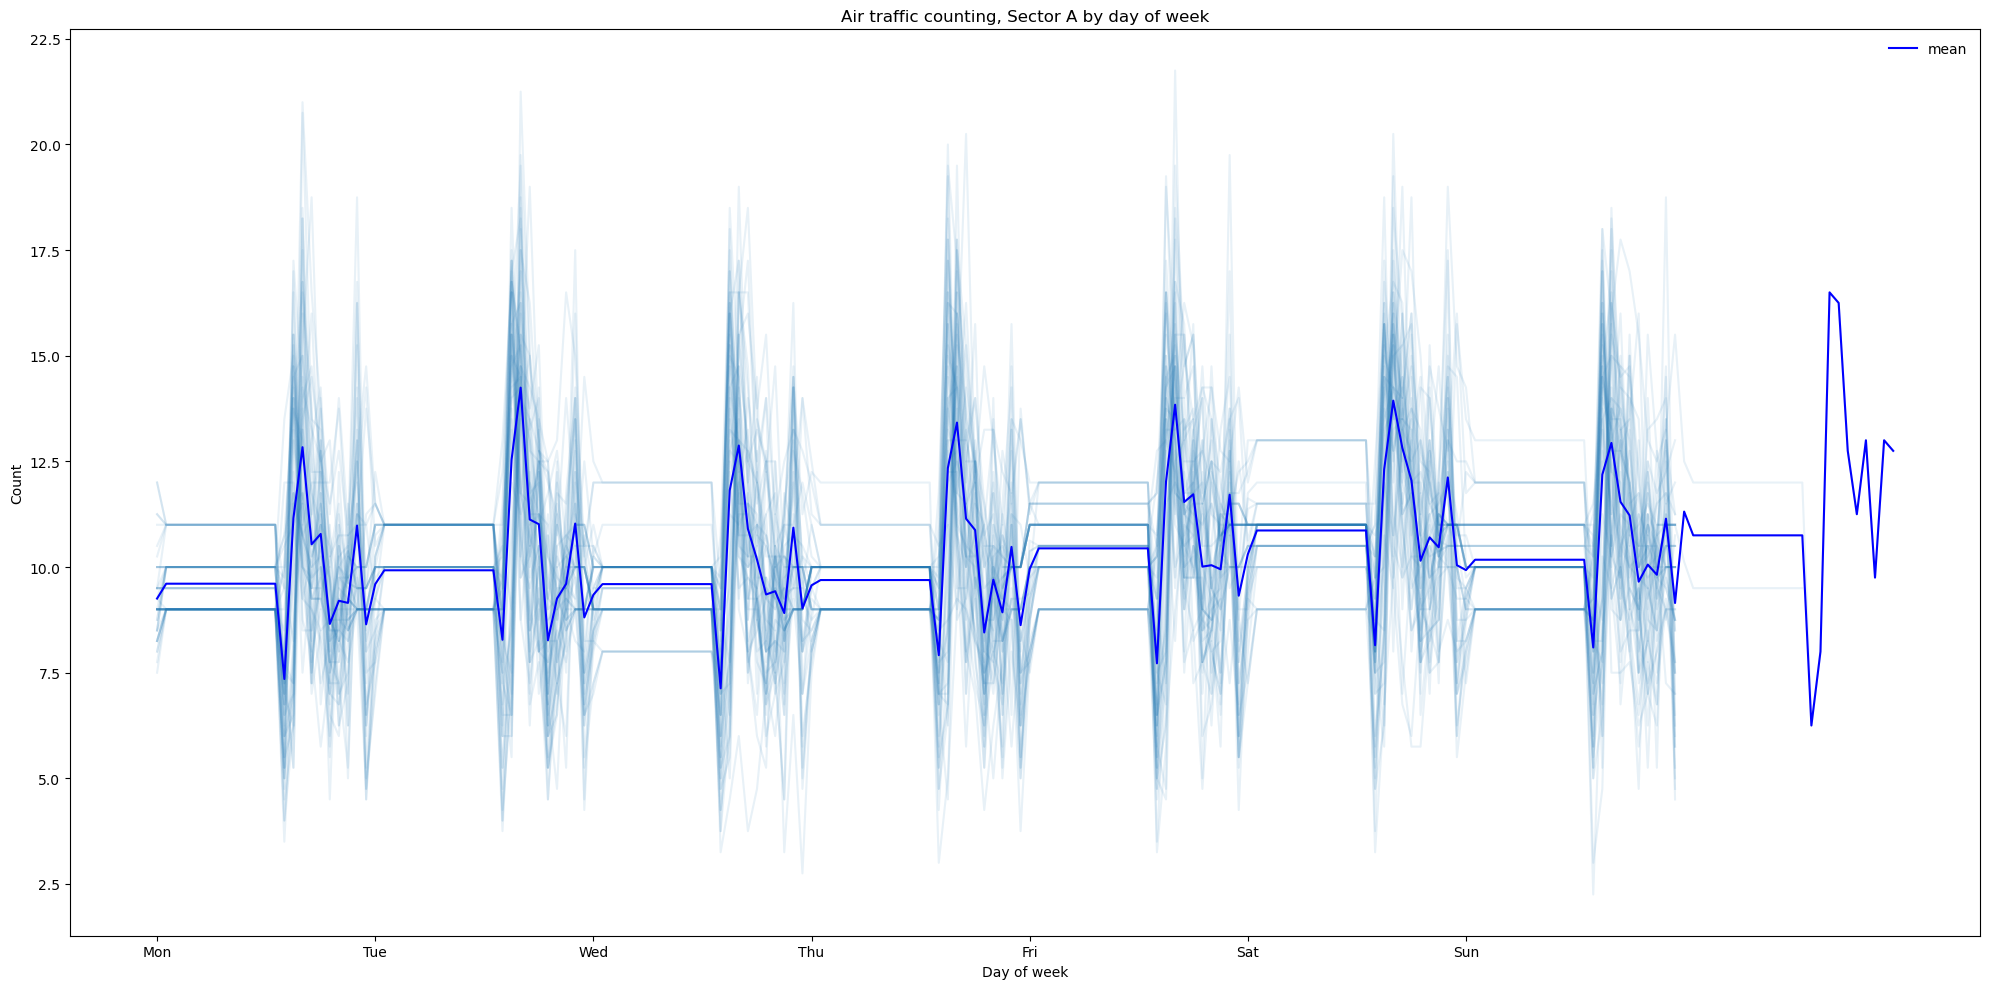

In [9]:
# Day of week
fig, ax = plt.subplots(figsize=[20, 10])
weekly_ts = []
sns_blue = sns.color_palette(as_cmap=True)
DAYS = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
for week, ts in df_h.groupby("week"):
    weekly_ts.append(ts.reset_index()["count"])
    ts.reset_index()["count"].plot(alpha=0.1, ax=ax, label="_no_legend_", color=sns_blue)
    plt.xticks(ticks=np.arange(0, 167, 24), labels=DAYS)

pd.concat(weekly_ts, axis=1).mean(axis=1).plot(
    ax=ax, color="blue", label="mean", legend=True
)

ax.set_ylabel("Count")
ax.set_title("Air traffic counting, Sector A by day of week")
ax.set_xlabel("Day of week")
ax.legend(loc="upper right", frameon=False)

plt.tight_layout()

## Single seasonal decompose ##

DAYLI SEASONAL DECOMPOSE

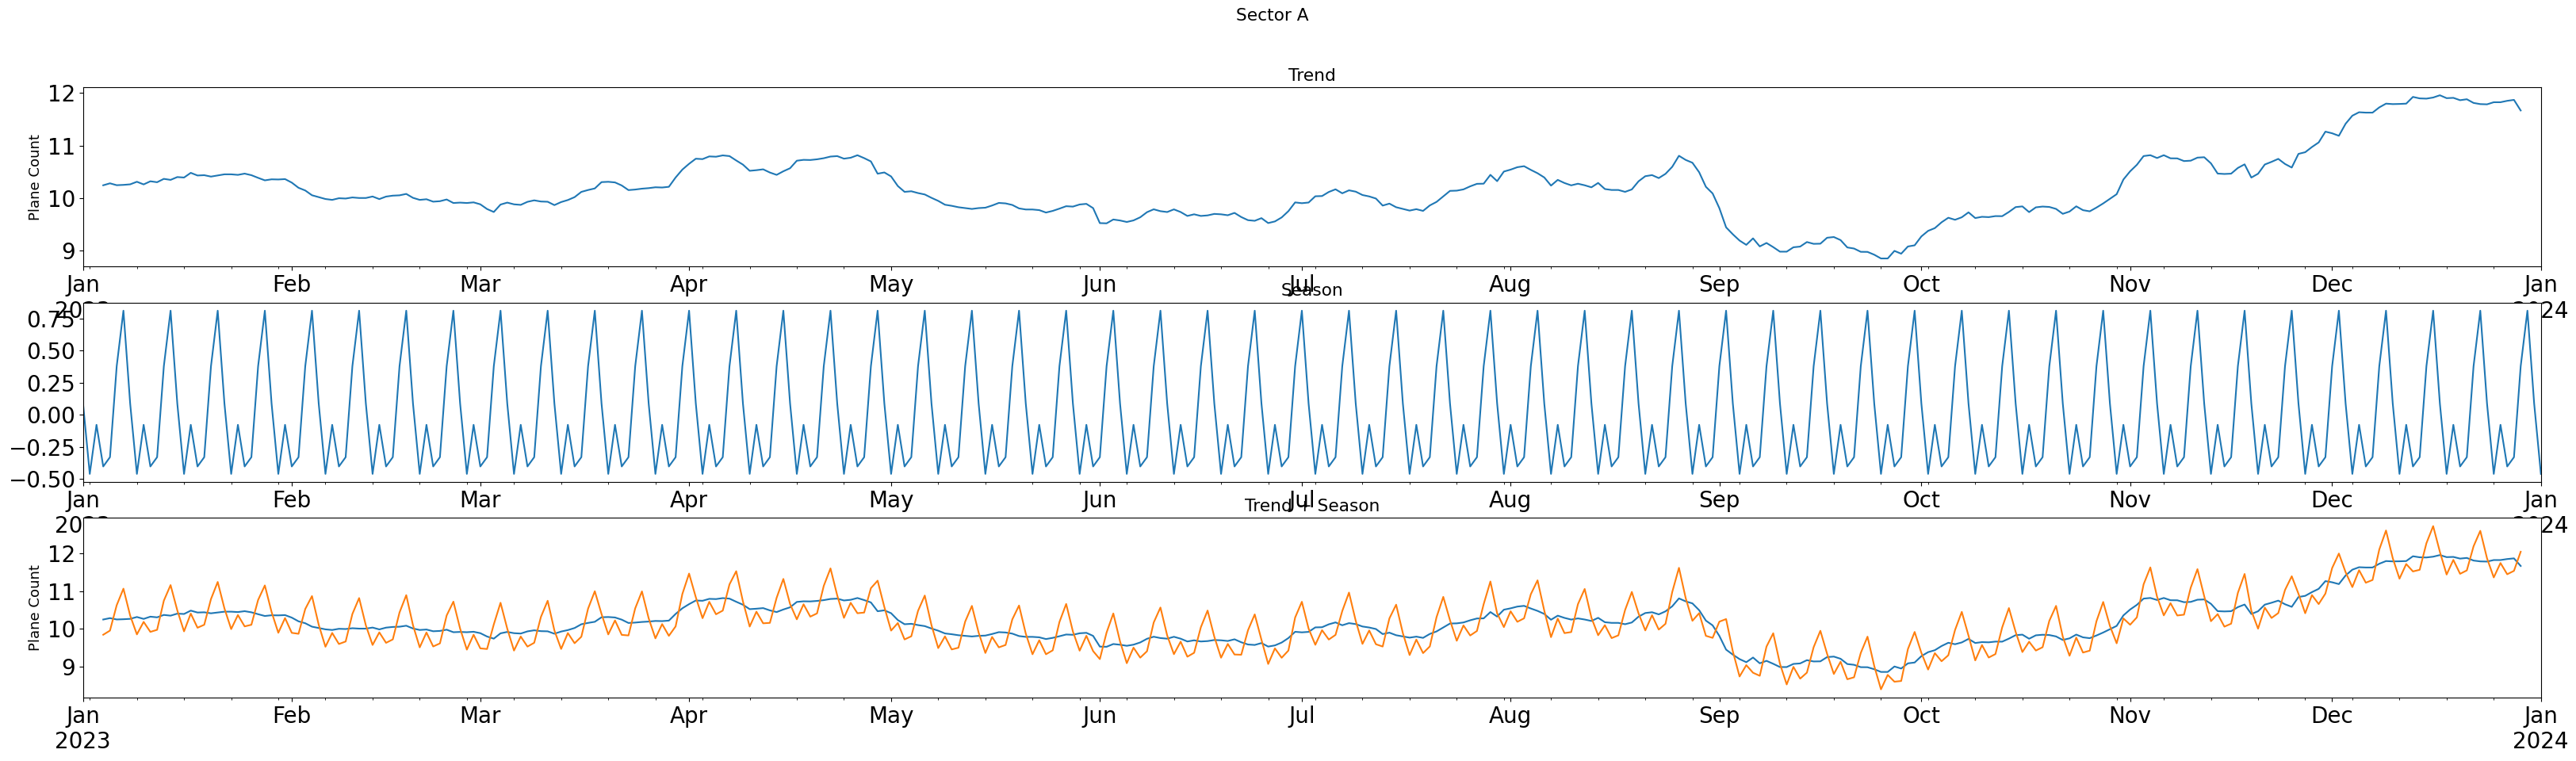

In [ ]:
# plt.figure(figsize=(10, 6))
fig, (ax_trend, ax_seasonality, ax_trend_season) = plt.subplots(3, 1, figsize=(40, 10))  # Create 1 row, 2 # 1, 3
results = seasonal_decompose(df['count'].resample('D').mean())   
    
trend = results.trend
seasonal = results.seasonal
residual = results.resid
    
trend.plot(ax=ax_trend_season, title="Trend + Season", ylabel="Plane Count",fontsize=20)
trend.plot(ax=ax_trend, title="Trend", ylabel="Plane Count",fontsize=20)
seasonal.plot(ax=ax_seasonality, title="Season",fontsize=20)
(seasonal + trend).plot(ax=ax_trend_season)
    
fig.suptitle(f"Sector {'A'}")
plt.show()

HOURLY SEASONAL DECOMPOSE

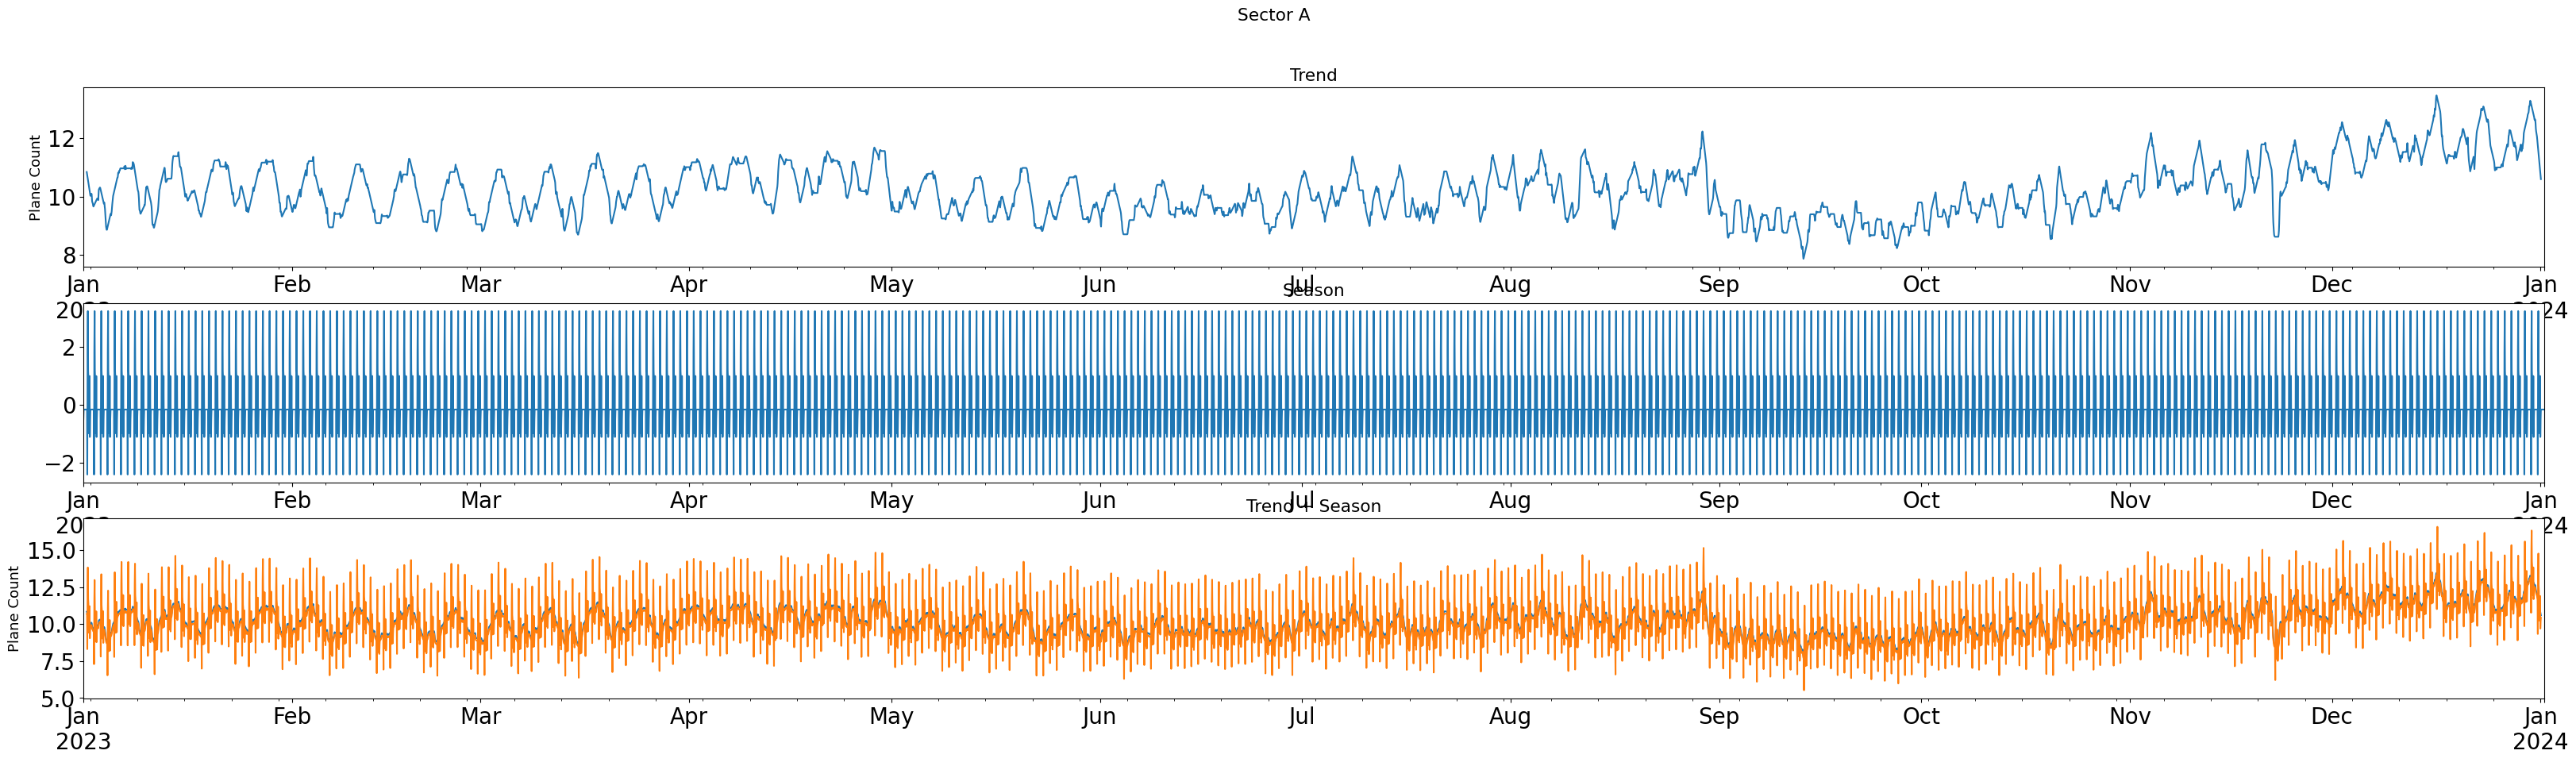

In [ ]:
# plt.figure(figsize=(10, 6))
fig, (ax_trend, ax_seasonality, ax_trend_season) = plt.subplots(3, 1, figsize=(40, 10))  # Create 1 row, 2 # 1, 3
results = seasonal_decompose(df['count'].resample('H').mean())   
    
trend = results.trend
seasonal = results.seasonal
residual = results.resid
    
trend.plot(ax=ax_trend_season, title="Trend + Season", ylabel="Plane Count",fontsize=20)
trend.plot(ax=ax_trend, title="Trend", ylabel="Plane Count",fontsize=20)
seasonal.plot(ax=ax_seasonality, title="Season",fontsize=20)
(seasonal + trend).plot(ax=ax_trend_season)
    
fig.suptitle(f"Sector {'A'}")
plt.show()

... data that are observed every minute might have an hourly seasonality (frequency=60), a daily seasonality (frequency=24x60=1440), a weekly seasonality (frequency=24x60x7=10080) and an annual seasonality (frequency=24x60x365.25=525960)

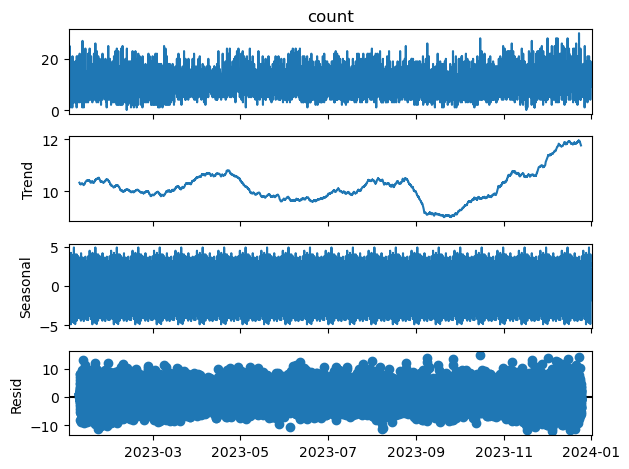

In [10]:
# Seasonal decompose
a = seasonal_decompose(df['count'], model = "Aditive", period=1440)    # df["y"], model = "Aditive","Multiplicative", period=12
a.plot();

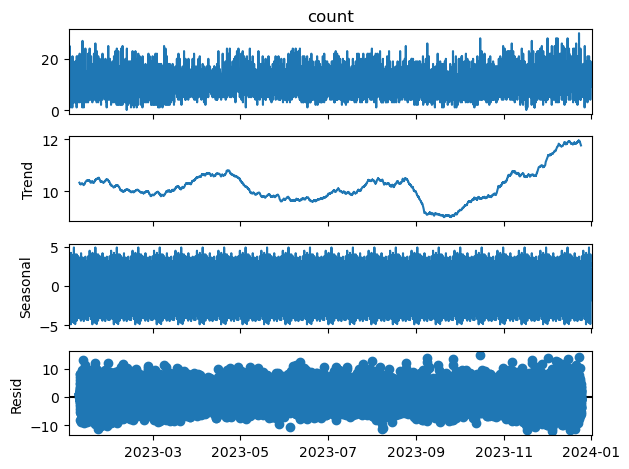

In [11]:
# Seasonal decompose
a = seasonal_decompose(df['count'], model = "Multiplicative", period=1440)    # df["y"], model = "Aditive","Multiplicative", period=12
a.plot();

### Analisis del movimiento de aeronaves en los sectores de control ###

En los sectores de control ATC se verifica constantemente la demanda y capacidad de los mismos. 

La demanda de aeronaves tiene una caracteristica multi-estacional.

Estacionalidad natural.
- Estacionalidad diaria: más demanda durante el día que a altas horas de la noche
- Estacionalidad semanal: los fines de semana frente a días laborables y semana santa
- Estacionalidad anual: la demanda en verano e invierno difiere debido a las temporada de alta y baja.

Estacionalidad agregada.
- Hay un ciclo estacional diario, desde las 00:15 a las 13:45. Se completo este intervalo de tiempo con la mediana minima de cada dia de semana del mes.

La demanda se registra con una granularidad de 15 minutos.

### Apply MSTL to the Air traffic demand dataset ###

MSTL: Multiple Seasonal Trend decomposition using Loess

Loess: Locally Estimated Scatterplot Smoothing

In [13]:
# Un período de 24 horas para estacionalidad diaria, un período de 24*7=168 horas para estacionalidad semanal.
mstl = MSTL(df_h["count"], periods=(24, 24 * 7), stl_kwargs={"seasonal_deg": 0})
res = mstl.fit()

The trend component, multiple seasonal components, and residual component can be accessed from the `trend`, `seasonal`, and `resid` attributes:

In [24]:
res.trend.head()

2023-01-01 00:00:00    10.410568
2023-01-01 01:00:00    10.408818
2023-01-01 02:00:00    10.407078
2023-01-01 03:00:00    10.405348
2023-01-01 04:00:00    10.403628
Freq: h, Name: trend, dtype: float64

In [25]:
res.seasonal.head()

seasonal_24  seasonal_168
2023-01-01 00:00:00    -0.070693      0.480210
2023-01-01 01:00:00    -0.067826      0.479655
2023-01-01 02:00:00    -0.065093      0.479106
2023-01-01 03:00:00    -0.062466      0.478570
2023-01-01 04:00:00    -0.059890      0.478047

In [26]:
res.resid.head()

2023-01-01 00:00:00    0.179915
2023-01-01 01:00:00    0.179353
2023-01-01 02:00:00    0.178908
2023-01-01 03:00:00    0.178548
2023-01-01 04:00:00    0.178216
Freq: h, Name: resid, dtype: float64

### Plot the MSTL decomposition ###

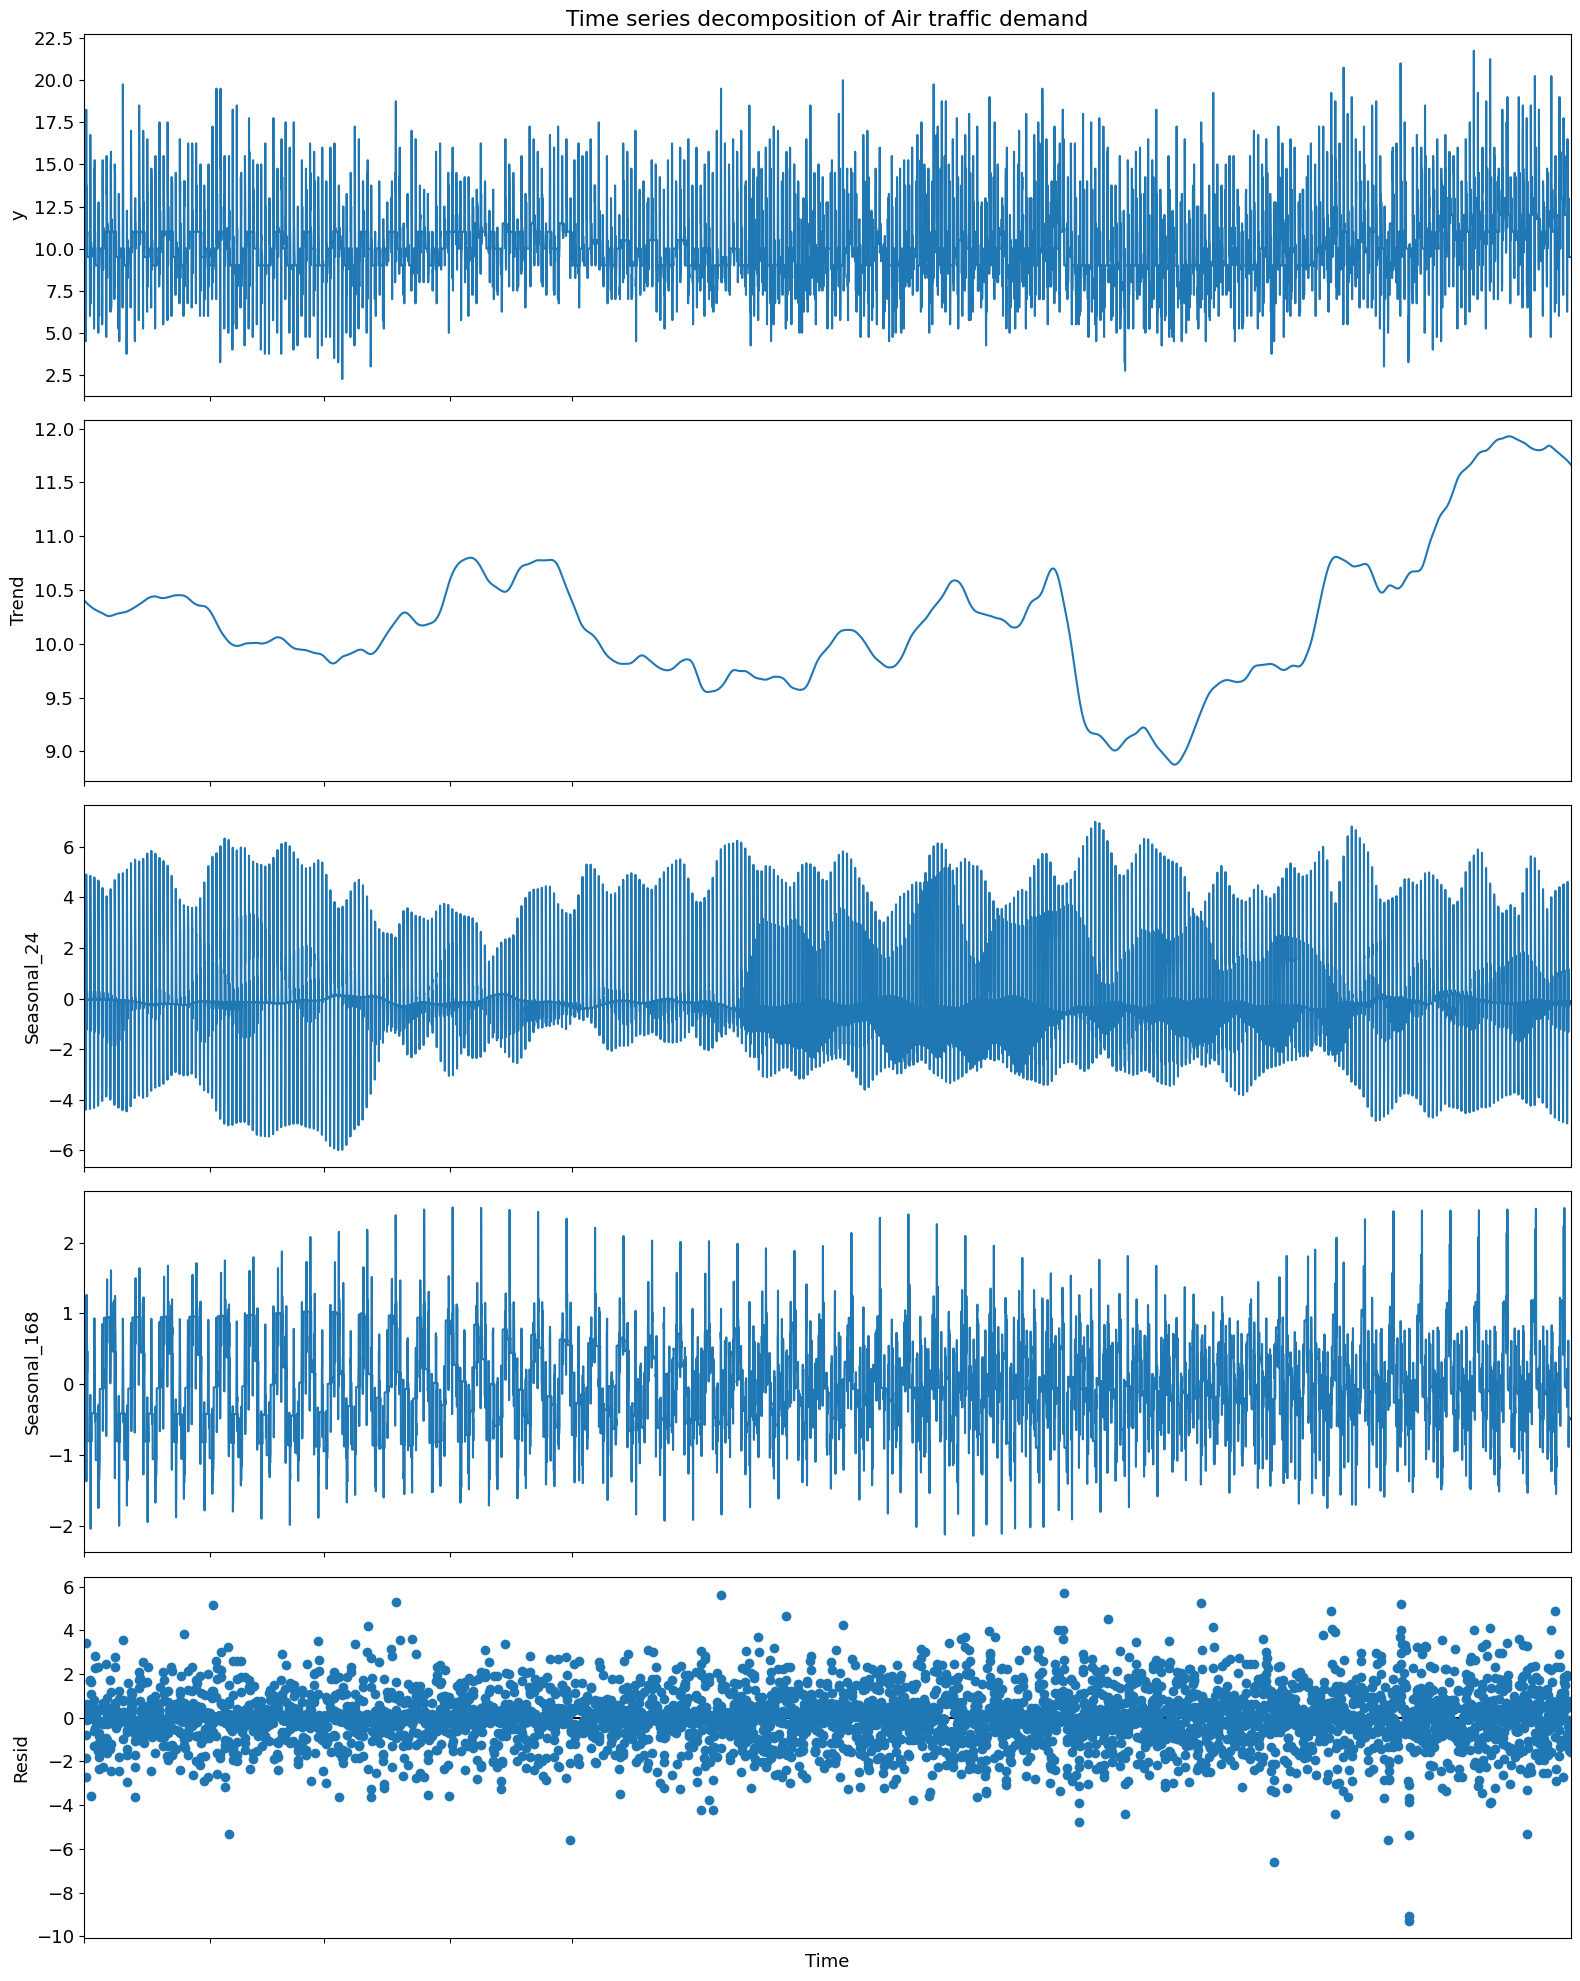

In [27]:
# Start with the plot from the results object `res`
plt.rc("figure", figsize=(16, 20))
plt.rc("font", size=13)
fig = res.plot()

# Make plot pretty
axs = fig.get_axes()

ax_last = axs[-1]
ax_last.xaxis.set_ticks(pd.date_range(start="2023-01-01", freq="MS", periods=5))
plt.setp(ax_last.get_xticklabels(), rotation=0, horizontalalignment="center")
for ax in axs[:-1]:
    #ax.get_shared_x_axes().join(ax, ax_last)
    ax.get_shared_x_axes().sharex = ax_last
    ax.xaxis.set_ticks(pd.date_range(start="2023-01-01", freq="MS", periods=5))
    ax.set_xticklabels([])
axs[0].set_ylabel("y")
axs[0].set_title("Time series decomposition of Air traffic demand")
ax_last.set_xlabel("Time")

plt.tight_layout()

### Daily and weekly seasonality ###

Let's inspect the seasonal components in a bit more detail and look at the first few days and weeks to examine the daily and weekly seasonality. 

We start with daily seasonality. One of the advantages of MSTL is that is allows us to capture seasonality which changes over time. We saw above that the daily seasonality is different in the summer and winter. So let's look at the daily seasonality from MSTL during January and May.

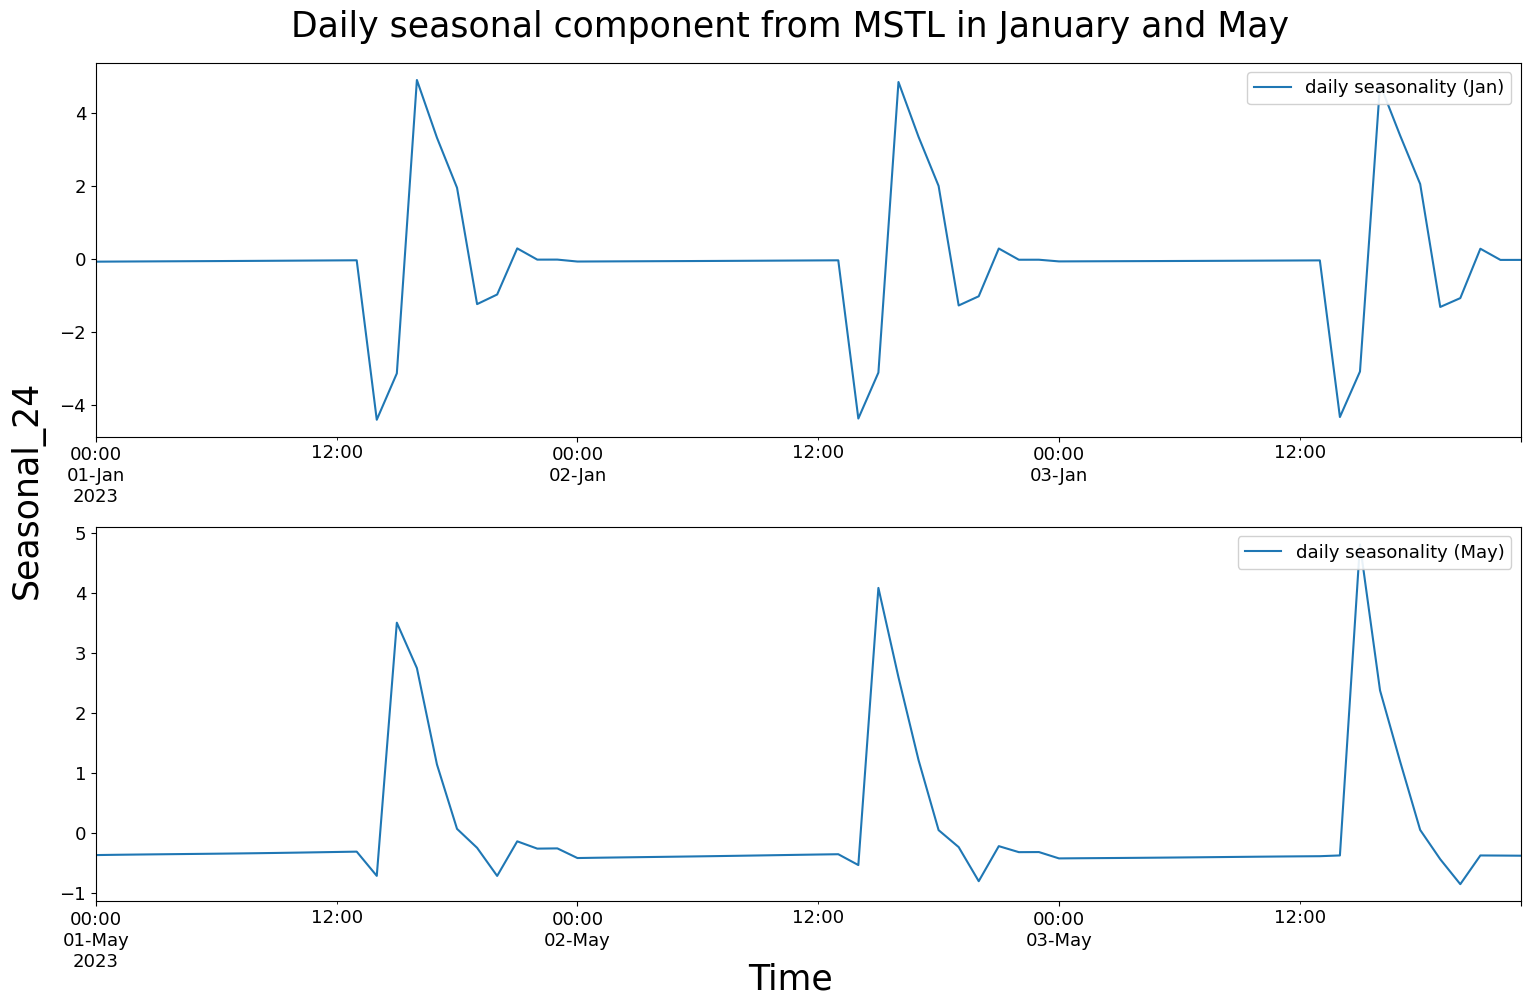

In [28]:
fig, ax = plt.subplots(nrows=2, figsize=[15, 10])
ax = ax.flatten()

# Plot daily seasonality in January
res.seasonal["seasonal_24"].iloc[: 24 * 3].plot(
    ax=ax[0], label="daily seasonality (Jan)", legend=True
)
ax[0].set_ylabel(None)
ax[0].set_xlabel(None)
ax[0].legend(loc="upper right", framealpha=0.9)

# Plot daily seasonality in May
mask = res.seasonal.index.month == 5
res.seasonal[mask]["seasonal_24"].iloc[: 24 * 3].plot(
    ax=ax[1], label="daily seasonality (May)", legend=True
)
ax[1].set_ylabel(None)
ax[1].set_xlabel(None)
ax[1].legend(loc="upper right", framealpha=0.9)

# Figure labels
fig.suptitle("Daily seasonal component from MSTL in January and May", fontsize=25)
fig.text(0.5, 0, "Time", ha="center", fontsize=25)
fig.text(-0.02, 0.5, "Seasonal_24", va="center", rotation="vertical", fontsize=25)

plt.tight_layout()

We can see that the daily seasonality of air traffic flow demand is well captured by MSTL. We see a single peak in January and two peaks in May.

We saw previously that weekends and weekdays have different demand. Let's see if this is picked up in the weekly seasonality.

In [14]:
start = pd.Timestamp("2023-01-02")  # Monday
end = start + pd.Timedelta("4W")
res.seasonal["seasonal_168"].loc[start:end]

timestamp
2023-01-02 00:00:00   -0.796310
2023-01-02 01:00:00   -0.796902
2023-01-02 02:00:00   -0.797472
2023-01-02 03:00:00   -0.798026
2023-01-02 04:00:00   -0.798571
                         ...   
2023-01-29 20:00:00    0.832294
2023-01-29 21:00:00    0.149973
2023-01-29 22:00:00    0.402667
2023-01-29 23:00:00    0.402279
2023-01-30 00:00:00   -0.812299
Freq: h, Name: seasonal_168, Length: 673, dtype: float64

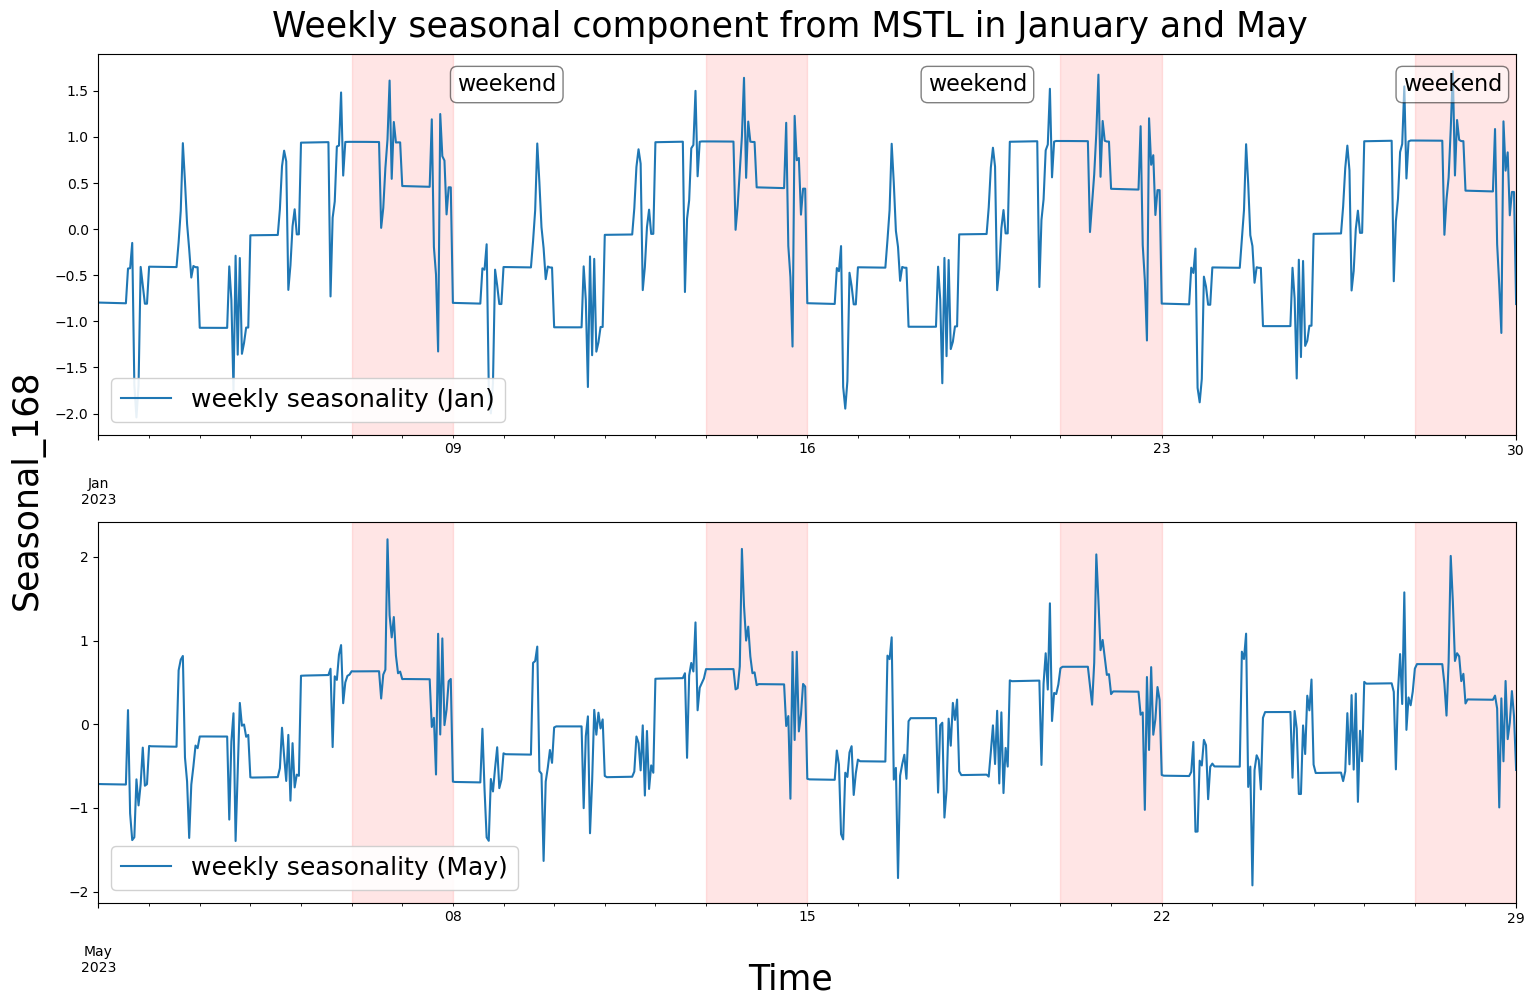

In [15]:
fig, ax = plt.subplots(nrows=2, figsize=[15, 10])
ax = ax.flatten()

# Plot weekly seasonality in January
start = pd.Timestamp("2023-01-02")  # Monday
end = start + pd.Timedelta("4W")
res.seasonal["seasonal_168"].loc[start:end].plot(
    ax=ax[0], label="weekly seasonality (Jan)", legend=True
)
ax[0].set_ylabel("seasonal_168")
ax[0].set_xlabel(None)
ax[0].set_ylabel(None)
ax[0].legend(loc="lower left", framealpha=0.9, fontsize=18)

props = dict(boxstyle="round", facecolor="white", alpha=0.5)
ax[0].text(
    0.253,
    0.95,
    "weekend",
    transform=ax[0].transAxes,
    fontsize=16,
    verticalalignment="top",
    bbox=props,
)

props = dict(boxstyle="round", facecolor="white", alpha=0.5)
ax[0].text(
    0.585,
    0.95,
    "weekend",
    transform=ax[0].transAxes,
    fontsize=16,
    verticalalignment="top",
    bbox=props,
)

props = dict(boxstyle="round", facecolor="white", alpha=0.5)
ax[0].text(
    0.92,
    0.95,
    "weekend",
    transform=ax[0].transAxes,
    fontsize=16,
    verticalalignment="top",
    bbox=props,
)

weekends = [
    ("2023-01-07", "2023-01-09"),
    ("2023-01-14", "2023-01-16"),
    ("2023-01-21", "2023-01-23"),
    ("2023-01-28", "2023-01-30"),
]
for start_, end_ in weekends:
    ax[0].axvspan(start_, end_, alpha=0.1, color="red")

# Plot weekly seasonality in May
mask = res.seasonal.index.month == 5
start = pd.Timestamp("2023-05-01")
end = start + pd.Timedelta("4W")
res.seasonal[mask]["seasonal_168"].loc[start:end].plot(
    ax=ax[1], label="weekly seasonality (May)", legend=True
)
ax[1].set_ylabel(None)
ax[1].set_xlabel(None)
ax[1].legend(loc="lower left", framealpha=0.9, fontsize=18)

weekends = [
    ("2023-05-06", "2023-05-08"),
    ("2023-05-13", "2023-05-15"),
    ("2023-05-20", "2023-05-22"),
    ("2023-05-27", "2023-05-29"),
]
for start_, end_ in weekends:
    ax[1].axvspan(start_, end_, alpha=0.1, color="red")

# Figure labels
fig.suptitle("Weekly seasonal component from MSTL in January and May", fontsize=25)
fig.text(0.5, 0, "Time", ha="center", fontsize=25)
fig.text(-0.02, 0.5, "Seasonal_168", va="center", rotation="vertical", fontsize=25)

plt.tight_layout()